In [6]:
# download a song to the workspace
from google.colab import files

upload = files.upload()

Saving Sililara_Sitha_Nayana_-_Soorya_Nagare_Athula_Adikari_Sarigama_lk.mp3 to Sililara_Sitha_Nayana_-_Soorya_Nagare_Athula_Adikari_Sarigama_lk (1).mp3


In [ ]:
# Loading the downloaded song

import librosa

song_path = "/content/Sililara_Sitha_Nayana_-_Soorya_Nagare_Athula_Adikari_Sarigama_lk.mp3"
audio , sr = librosa.load(song_path, sr = None)

# Display the sampling rate and the shape of the audio signal
print(f'Sampling Rate: {sr} Hz')
print(f'Audio Signal Shape: {audio.shape}')

Sampling Rate: 44100 Hz
Audio Signal Shape: (10233216,)


# Preprocess the Audio File

In [ ]:
import numpy as np

# Define window size and hop size
frame_size = 2048
hop_size = 512

# Framing the audio
frames = librosa.util.frame(audio, frame_length=frame_size, hop_length=hop_size).T

# Print the size of frames
print(f'frame size : {frames.shape}')

frame size : (19983, 2048)


In [ ]:
from scipy.fftpack import fft

# Compute the FFT for each frame
fft_frames = np.fft.rfft(frames, axis=1)


# Identifying the Fundamental Frequency

In [ ]:
# Frequency axis
frequencies = np.fft.rfftfreq(frame_size, 1/sr)

def find_fundamental_frequency(fft_frame, frequencies):
    magnitude_spectrum = np.abs(fft_frame)
    max_index = np.argmax(magnitude_spectrum)
    fundamental_freq = frequencies[max_index]
    return fundamental_freq

# Estimate pitch for each frame
pitch_estimates = np.array([find_fundamental_frequency(frame, frequencies) for frame in fft_frames])


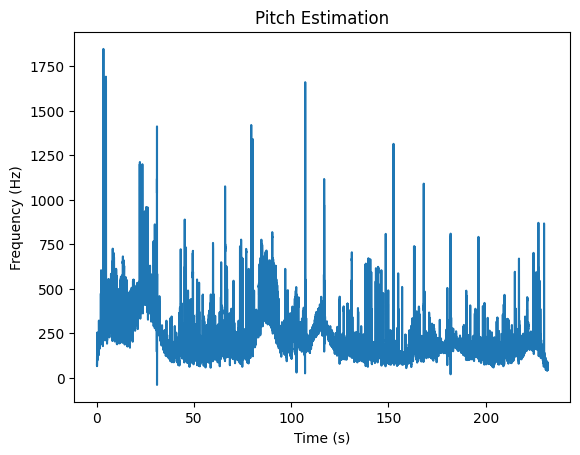

In [ ]:
import matplotlib.pyplot as plt

# Smooth pitch estimates using a median filter
pitch_estimates = librosa.effects.harmonic(pitch_estimates)

# Plot the pitch contour
times = np.arange(len(pitch_estimates)) * hop_size / sr
plt.plot(times, pitch_estimates)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Pitch Estimation')
plt.show()


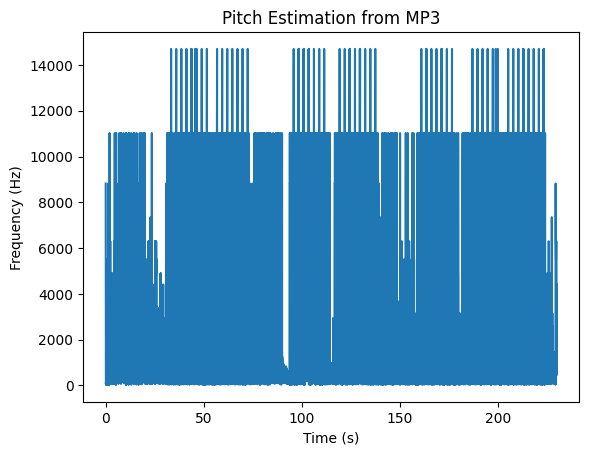

In [5]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def autocorr(x):
    """Compute the autocorrelation of a signal x."""
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

def find_pitch(signal, sr, frame_size, hop_size):
    pitches = []
    for i in range(0, len(signal) - frame_size, hop_size):
        frame = signal[i:i + frame_size]

        # Compute the autocorrelation
        autocorrelation = autocorr(frame)
        d = np.diff(autocorrelation)

        # Check for positive slope change
        try:
            start = np.nonzero(d > 0)[0][0]  # Find the first positive slope change
            peak = np.argmax(autocorrelation[start:]) + start
            pitch = sr / peak
        except IndexError:
            # If no positive slope is found, assign a default pitch or None
            pitch = None

        pitches.append(pitch)
    return pitches

# Load MP3 file
filename = "/content/Sililara_Sitha_Nayana_-_Soorya_Nagare_Athula_Adikari_Sarigama_lk.mp3"
audio, sr = librosa.load(filename, sr=None)

# Define frame size and hop size
frame_size = 2048
hop_size = 512

# Estimate pitch
pitches = find_pitch(audio, sr, frame_size, hop_size)

# Filter out None values for plotting
pitches = np.array(pitches)
pitches = pitches[pitches != None]

# Plot the results
times = np.arange(len(pitches)) * hop_size / sr
plt.plot(times, pitches)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Pitch Estimation from MP3')
plt.show()


# Harmonic Product Spectrum

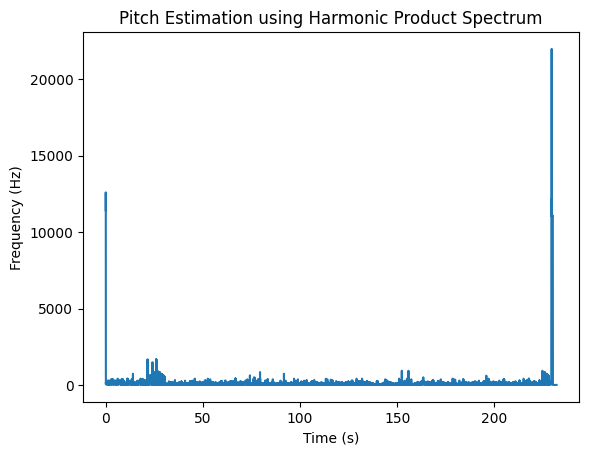

In [3]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def harmonic_product_spectrum(magnitude_spectrum, num_harmonics):
    hps = magnitude_spectrum.copy()
    for harmonic in range(2, num_harmonics + 1):
        # Downsample the spectrum by the harmonic number
        downsampled_spectrum = magnitude_spectrum[::harmonic]
        # Multiply the original spectrum by the downsampled spectrum
        hps[:len(downsampled_spectrum)] *= downsampled_spectrum
    return hps

def find_pitch_hps(signal, sr, frame_size, hop_size, num_harmonics=5):
    pitches = []
    frequencies = np.fft.rfftfreq(frame_size, 1/sr)
    for i in range(0, len(signal) - frame_size, hop_size):
        frame = signal[i:i + frame_size]
        magnitude_spectrum = np.abs(np.fft.rfft(frame))

        # Apply Harmonic Product Spectrum
        hps = harmonic_product_spectrum(magnitude_spectrum, num_harmonics)

        # Find the peak in the HPS
        peak_index = np.argmax(hps)
        pitch = frequencies[peak_index]
        pitches.append(pitch)

    return pitches

# Load MP3 file
filename = "/content/Sililara_Sitha_Nayana_-_Soorya_Nagare_Athula_Adikari_Sarigama_lk.mp3"
audio, sr = librosa.load(filename, sr=None)

# Define frame size and hop size
frame_size = 2048
hop_size = 512

# Estimate pitch using HPS
pitches_hps = find_pitch_hps(audio, sr, frame_size, hop_size)

# Plot the results
times = np.arange(len(pitches_hps)) * hop_size / sr
plt.plot(times, pitches_hps)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Pitch Estimation using Harmonic Product Spectrum')
plt.show()


In [7]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

def difference_function(x, n, tau):
    """Calculate the difference function."""
    return np.sum((x[:n-tau] - x[tau:n]) ** 2)

def cumulative_mean_normalized_difference_function(df):
    """Calculate the cumulative mean normalized difference function."""
    cmndf = np.zeros_like(df, dtype=float)
    cmndf[0] = 1
    for tau in range(1, len(df)):
        cmndf[tau] = df[tau] / ((1/tau) * np.sum(df[1:tau+1]))
    return cmndf

def yin_pitch_detection(signal, sr, frame_size=2048, hop_size=512, threshold=0.1):
    pitches = []
    for i in range(0, len(signal) - frame_size, hop_size):
        frame = signal[i:i + frame_size]

        # Step 1: Difference function
        df = np.array([difference_function(frame, frame_size, tau) for tau in range(frame_size)])

        # Step 2: Cumulative mean normalized difference function
        cmndf = cumulative_mean_normalized_difference_function(df)

        # Step 3: Find the first local minimum below the threshold
        tau_min = np.where(cmndf < threshold)[0]
        if len(tau_min) == 0:
            pitch = 0  # No pitch detected
        else:
            tau = tau_min[0]
            pitch = sr / tau

        pitches.append(pitch)

    return np.array(pitches)

# Load an audio file (MP3)
filename =  "/content/Sililara_Sitha_Nayana_-_Soorya_Nagare_Athula_Adikari_Sarigama_lk.mp3"
audio, sr = librosa.load(filename, sr=None)

# Apply YIN pitch detection
pitches_yin = yin_pitch_detection(audio, sr)

# Plot the results
times = np.arange(len(pitches_yin)) * 512 / sr
plt.plot(times, pitches_yin)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Pitch Estimation using YIN Algorithm')
plt.show()


KeyboardInterrupt: 

# Employing Neural Networks in Pitch Detection

In [9]:
!pip install tensorflow


In [11]:
# Creating the model
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split

def generate_sine_wave(frequency, sr=22050, duration=1.0):
    """Generate a sine wave with a given frequency."""
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    return 0.5 * np.sin(2 * np.pi * frequency * t)

# Parameters
sr = 22050  # Sample rate
duration = 1.0  # Duration of each audio clip
frequencies = np.arange(50, 1000, 50)  # Frequencies to generate (e.g., 50Hz to 1000Hz)
n_samples = 100  # Number of samples per frequency

X = []
y = []

for freq in frequencies:
    for _ in range(n_samples):
        sine_wave = generate_sine_wave(freq, sr=sr, duration=duration)
        mfccs = librosa.feature.mfcc(y=sine_wave, sr=sr, n_mfcc=13)
        X.append(mfccs)
        y.append(freq)

X = np.array(X)
y = np.array(y)

# Reshape X to have a channel dimension (for CNN input)
X = X[..., np.newaxis]

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Assuming X_train has been preprocessed with correct dimensions
input_shape = (X_train.shape[1], X_train.shape[2], 1)  # Example: (13, 87, 1) for MFCCs

# Build a CNN model
model = Sequential([
    Input(shape=input_shape),  # Use Input() to define the input shape
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1)  # Output layer for regression (predicting frequency)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 13, 44, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 22, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 6, 22, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 6, 22, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 3, 11, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 3, 11, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 11, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 257,025 (1004.00 KB)

 Trainable params: 257,025 (1004.00 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
import librosa
import numpy as np

def preprocess_audio_file(filename, sr=22050, duration=1.0, n_mfcc=13):
    """Preprocess an audio file for CNN input.

    Args:
    - filename: Path to the MP3 file.
    - sr: Sample rate for loading the audio file.
    - duration: Duration to which the audio is trimmed or padded.
    - n_mfcc: Number of MFCCs to extract.

    Returns:
    - mfccs: MFCC features reshaped for CNN input.
    """
    # Load the audio file
    audio, _ = librosa.load(filename, sr=sr, duration=duration)

    # Pad or trim the audio to ensure a fixed length
    if len(audio) < sr * duration:
        padding = sr * duration - len(audio)
        audio = np.pad(audio, (0, int(padding)), 'constant')
    elif len(audio) > sr * duration:
        audio = audio[:int(sr * duration)]

    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

    # Reshape MFCCs to match the CNN input shape
    mfccs = mfccs[..., np.newaxis]

    return mfccs

# Path to the MP3 file
filename = "/content/Sililara_Sitha_Nayana_-_Soorya_Nagare_Athula_Adikari_Sarigama_lk.mp3"

# Preprocess the audio file
mfccs = preprocess_audio_file(filename)

# The model expects a batch of inputs, so add an extra dimension to create a batch of size 1
mfccs = np.expand_dims(mfccs, axis=0)

# Predict the pitch using the CNN model
predicted_frequency = model.predict(mfccs)

print(predicted_frequency)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[4.0944176]]
